In [ ]:
import numpy as np

In [ ]:
major_folder_path_1 = '/content/drive/MyDrive/NYUAD-Courses/Deep Learning/Project/Data/San Bernardino - 6 - story Hotel/Files Extracted Filtered Moded 002'
major_folder_path_2 = '/content/drive/MyDrive/NYUAD-Courses/Deep Learning/Project/Data/San Bernardino - 6 - story Hotel/Files Extracted Filtered Moded 003'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class FileData:
  def __init__(self,name,acc_index,vel_index,dsp_index,lst_index,dt_acc,dt_vel,dt_dsp,unit_acc,unit_vel,unit_dsp,acc_values,vel_values,dsp_values,dt_sampling,acc_values_sampled,vel_values_sampled,dsp_values_sampled):
    self.name = name
    self.acc_index = acc_index
    self.vel_index = vel_index
    self.dsp_index = dsp_index
    self.lst_index = lst_index
    self.dt_acc = dt_acc
    self.dt_vel = dt_vel
    self.dt_dsp = dt_dsp
    self.unit_acc = unit_acc
    self.unit_vel = unit_vel
    self.unit_dsp = unit_dsp
    self.acc_values = acc_values
    self.vel_values = vel_values
    self.dsp_values = dsp_values
    self.dt_sampling = dt_sampling
    self.acc_values_sampled = acc_values_sampled
    self.vel_values_sampled = vel_values_sampled
    self.dsp_values_sampled = dsp_values_sampled
    self.ID = 0
    self.u_r = None
    self.ud_r = None
    self.udd_r = None
    self.t = None # time vector

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(y,title):
  plt.rcParams["figure.figsize"] = [15, 3.50]
  plt.rcParams["figure.autolayout"] = True
  plt.title(title)
  plt.plot(y, color="red")
  plt.show()

In [ ]:
import pickle
import numpy as np

def save_object_with_pickle(file_path,file_name,data):
    with open(f'{file_path}/{file_name}.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


def load_object_with_pickle(file_path,file_name):
    with open(f'{file_path}/{file_name}.pickle', 'rb') as f:
        data = pickle.load(f)
        return data

In [ ]:
files_data = load_object_with_pickle(major_folder_path_1,'all_eq_processed_data_ID_m')

In [ ]:
def Generate_K(k_values):
  DOF, = k_values.shape
  K = np.zeros((DOF, DOF))

  for i in range(DOF):
    for j in range(DOF):
      if i == j :
        if i == DOF-1:
          K[i,j]=k_values[i]
        else:
          K[i,j]=k_values[i]+k_values[i+1]
      if (j == i+1):
          K[i,j]=-k_values[j]
      if (j+1 == i):
          K[i,j]=-k_values[i]

  return K

def Update_K(k_values_init,u_values,u_limits,modifiers):
  k_values = np.zeros_like(k_values_init)
  DOF, = k_values.shape
  for i in range(DOF):
    if abs(u_values[i]) > u_limits[i]:
      k_values[i] = k_values_init[i] * modifiers[i]
    else:
      k_values[i] = k_values_init[i]
  K = Generate_K(k_values)
  return K

In [ ]:
def Generalized_Alpha(K,M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM):
    DOF,n=R.shape

    t = np.arange(0,n*dt,dt)

    # Defining Variables
    u   =  np.zeros((DOF, n))
    ud  =  np.zeros((DOF, n))
    udd =  np.zeros((DOF, n))
    # R^ or P^
    R_hat =  np.zeros((DOF, n))
    # Method Constants
    b0 = alphaF
    b1 = 1-alphaF
    b2 = alphaM
    b3 = 1-alphaM
    a0 = (1-alphaM) / (beta*dt*dt)
    a1 = (1-alphaF)*gamma / (beta*dt)
    a2 = (1-alphaM) / (beta*dt)
    a3 = ((1-alphaM) / (2*beta))-1
    a4 = ((1-alphaF)*gamma / beta)-1
    a5 = ((gamma / (2*beta))-1)*(1-alphaF)*dt
    a6 = 1 / (beta*dt*dt)
    a7 = 1 / (beta*dt)
    a8 = (1 / (2*beta))-1
    a9 = gamma / (beta*dt)
    a10 = (gamma / beta)-1
    a11 = ((gamma / (2*beta))-1)*dt
    K_hat = b1*K+a0*M+a1*C
    inv_K_hat=np.linalg.inv(K_hat)
    inv_M=np.linalg.inv(M)
    # starting algorithm
    u[:,0] = u0
    ud[:,0] = ud0
    udd[:,0] = inv_M @ (R[:,0] - K @ u[:,0] - C @ ud[:,0])

    for i in range(n-1):
        R_hat[:,i+1] = b1*R[:,i+1]+b0*R[:,i]- b0*K @ u[:,i] + M @ (a0*u[:,i]+a2*ud[:,i]+a3*udd[:,i]) + C @ (a1*u[:,i]+a4*ud[:,i]+a5*udd[:,i])
        u[:,i+1] = inv_K_hat @ R_hat[:,i+1]
        ud[:,i+1] = a9*(u[:,i+1]-u[:,i])-a10*ud[:,i]-a11*udd[:,i]
        udd[:,i+1] = a6*(u[:,i+1]-u[:,i])-a7*ud[:,i]-a8*udd[:,i]
        #udd[:,i+1] = inv_M @ (R[:,i+1] - K @ u[:,i+1] - C @ ud[:,i+1])

    return t,u,ud,udd


In [ ]:
def Generalized_Alpha_NonLinear(K_data,M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM):
    (k_values_init,u_limits,modifiers) =  K_data

    DOF,n=R.shape

    t = np.arange(0,n*dt,dt)

    # Defining Variables
    du  =  np.zeros((DOF, n))
    u   =  np.zeros((DOF, n))
    ud  =  np.zeros((DOF, n))
    udd =  np.zeros((DOF, n))
    # R^ or P^
    R_hat =  np.zeros((DOF, n))
    dR_hat =  np.zeros((DOF, n))
    # Method Constants
    b0 = alphaF
    b1 = 1-alphaF
    b2 = alphaM
    b3 = 1-alphaM
    a0 = (1-alphaM) / (beta*dt*dt)
    a1 = (1-alphaF)*gamma / (beta*dt)
    a2 = (1-alphaM) / (beta*dt)
    a3 = ((1-alphaM) / (2*beta))-1
    a4 = ((1-alphaF)*gamma / beta)-1
    a5 = ((gamma / (2*beta))-1)*(1-alphaF)*dt
    a6 = 1 / (beta*dt*dt)
    a7 = 1 / (beta*dt)
    a8 = (1 / (2*beta))-1
    a9 = gamma / (beta*dt)
    a10 = (gamma / beta)-1
    a11 = ((gamma / (2*beta))-1)*dt
    # starting algorithm
    u[:,0] = u0
    ud[:,0] = ud0

    K = Update_K(k_values_init,u[:,0],u_limits,modifiers)
    K_hat = b1*K+a0*M+a1*C
    #inv_K_hat=np.linalg.inv(K_hat)
    #inv_M=np.linalg.inv(M)
    #udd[:,0] = inv_M @ (R[:,0] - K @ u[:,0] - C @ ud[:,0])
    udd[:,0] = np.linalg.solve(M , (R[:,0] - K @ u[:,0] - C @ ud[:,0]))


    last_elastic_force = K @ u[:,0]
    for i in range(n-1):
        R_hat[:,i+1] = b1*R[:,i+1]+b0*R[:,i]- b0*last_elastic_force + M @ (a0*u[:,i]+a2*ud[:,i]+a3*udd[:,i]) + C @ (a1*u[:,i]+a4*ud[:,i]+a5*udd[:,i])
        dR_hat[:,i+1] = R_hat[:,i+1] - R_hat[:,i]
        du[:,i+1] = np.linalg.solve(K_hat , dR_hat[:,i+1])
        u[:,i+1] = u[:,i] + du[:,i+1]
        ud[:,i+1] = a9*(u[:,i+1]-u[:,i])-a10*ud[:,i]-a11*udd[:,i]
        udd[:,i+1] = a6*(u[:,i+1]-u[:,i])-a7*ud[:,i]-a8*udd[:,i]
        #udd[:,i+1] = inv_M @ (R[:,i+1] - K @ u[:,i+1] - C @ ud[:,i+1])

        last_elastic_force += K @ du[:,i+1]
        K = Update_K(k_values_init,u[:,i+1],u_limits,modifiers)
        K_hat = b1*K+a0*M+a1*C
        # print('K',K)
        # print('K_hat',K_hat)
        # print('last_elastic_force',last_elastic_force)
        # if i > 10:
        #   break

    return t,u,ud,udd


In [ ]:
## Update_K(np.array([5.16,6.84,6.84]) , np.array([-1.,-2,-3.0]), np.array([1,2,3]), np.array([0.2,0.2,0.2]))
## C = np.array([[175,-50,0],
##               [-50,100,-50],
##               [0,-50,50]])
##
## M = np.array([[98.3,0,0],
##               [0,98.3,0],
##               [0,0,98.3]])

In [ ]:
import math

##Model Properties
NDOF=1
m=1
k=m*((2*math.pi/0.41)**2)
w=math.sqrt(k/m)
f=w/(2*math.pi)
T=1/f
c_cr=2*math.sqrt(k*m)
zeta=2.35/100
c=zeta*c_cr
M=np.ones((1,1))*m
K=np.ones((1,1))*k
C=np.ones((1,1))*c
u0=np.zeros((NDOF, 1))
ud0=np.zeros((NDOF, 1))
dt=0.005
print(f'T={T}')
print(f'M={M}')
print(f'K={K}')
print(f'C={C}')
##Generalized Alpha Coefficients
gamma=0.5
beta=0.25
alphaF=0.0
alphaM=0.0

T=0.41000000000000003
M=[[1.]]
K=[[234.85078884]]
C=[[0.72026758]]


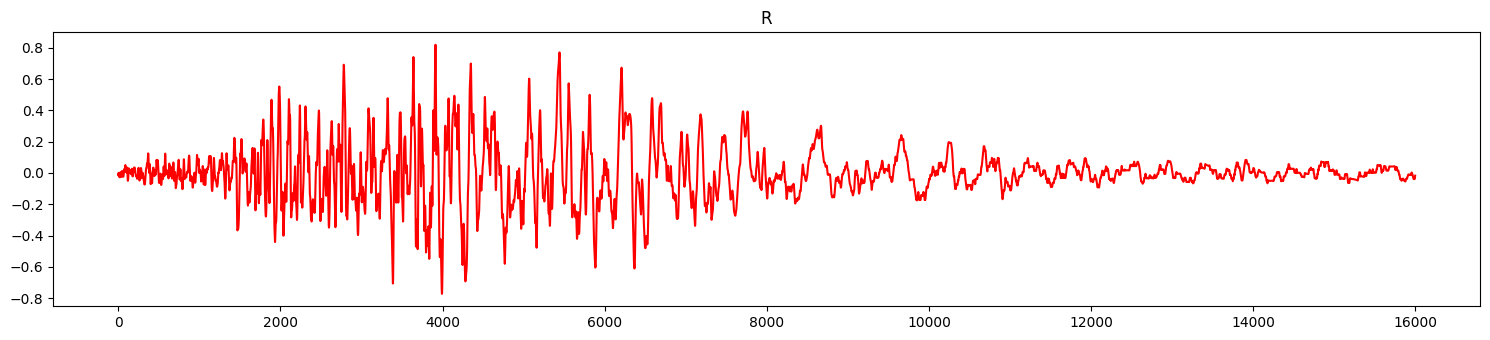

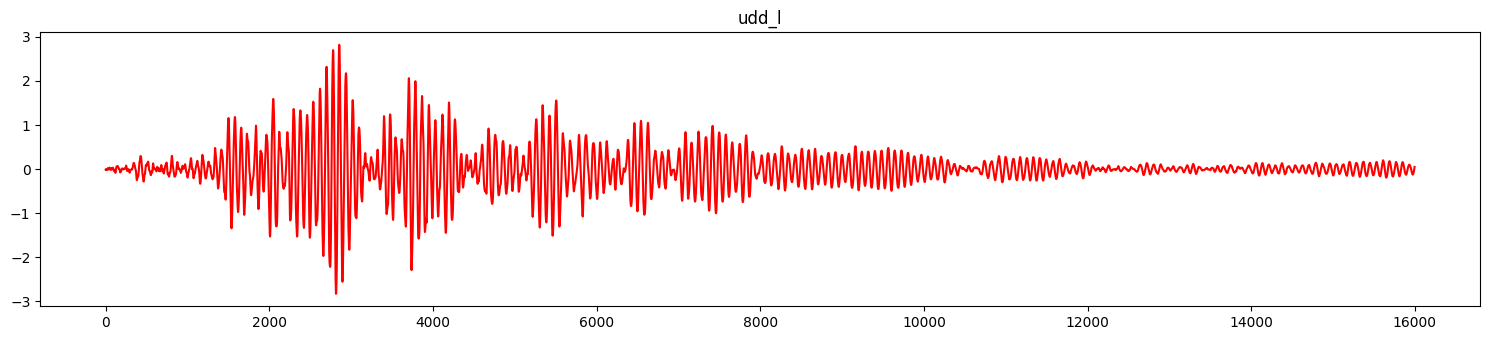

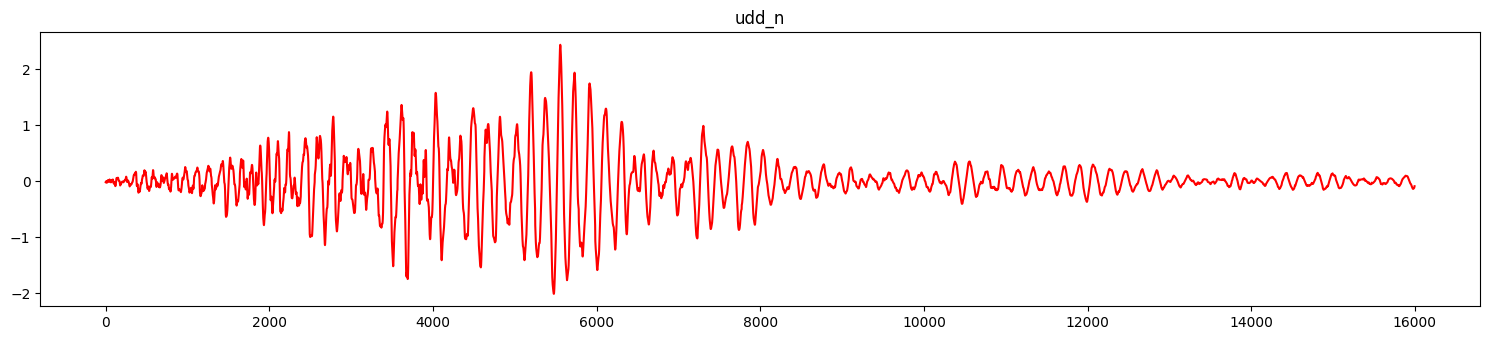

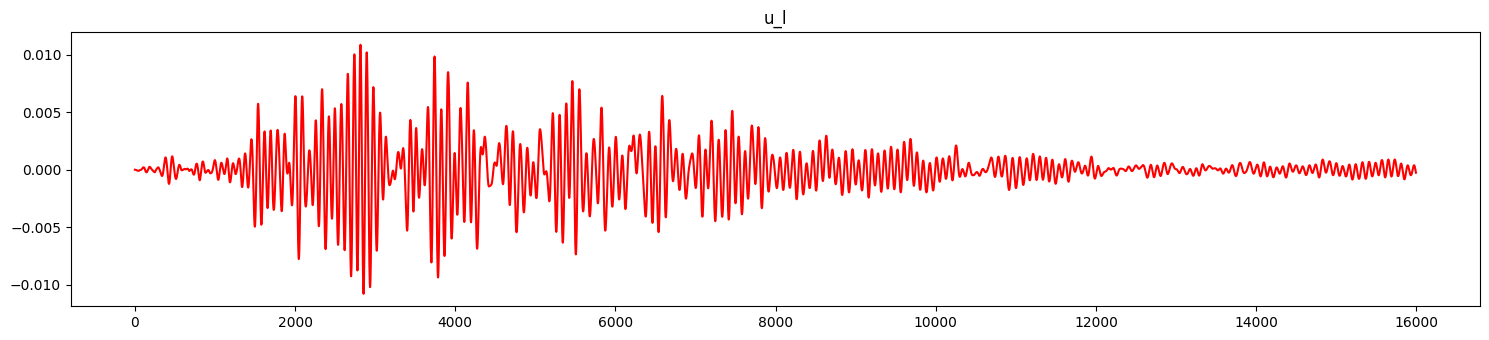

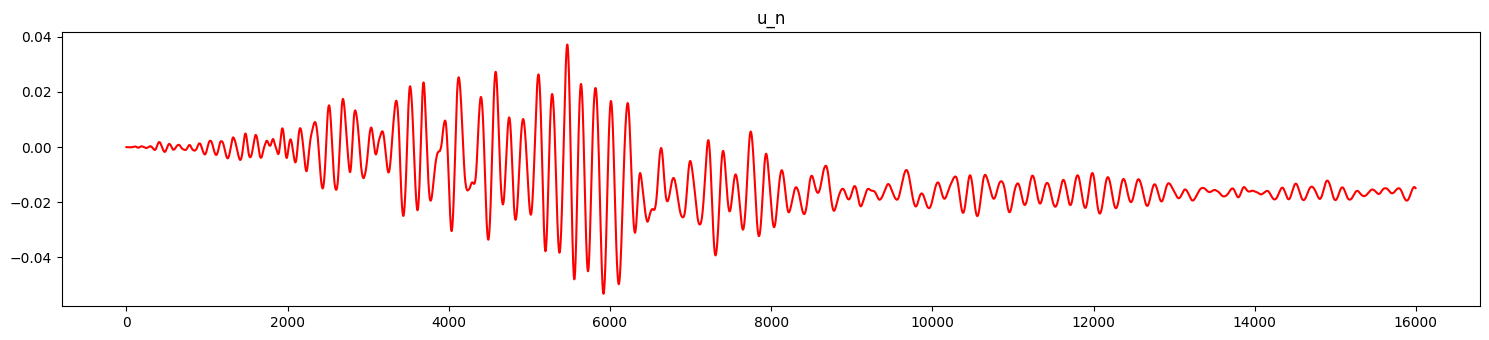

In [ ]:
R=files_data[18].acc_values_sampled.reshape((NDOF, -1))
t_l,u_l,ud_l,udd_l = Generalized_Alpha(K,M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM) # Relative Response
t_n,u_n,ud_n,udd_n = Generalized_Alpha_NonLinear((np.array([k]) , np.array([0.0002]), np.array([0.2])),M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM) # Relative Response
plot_series((R).reshape(-1),'R')
plot_series((udd_l).reshape(-1),'udd_l')
plot_series((udd_n).reshape(-1),'udd_n')
plot_series((u_l).reshape(-1),'u_l')
plot_series((u_n).reshape(-1),'u_n')

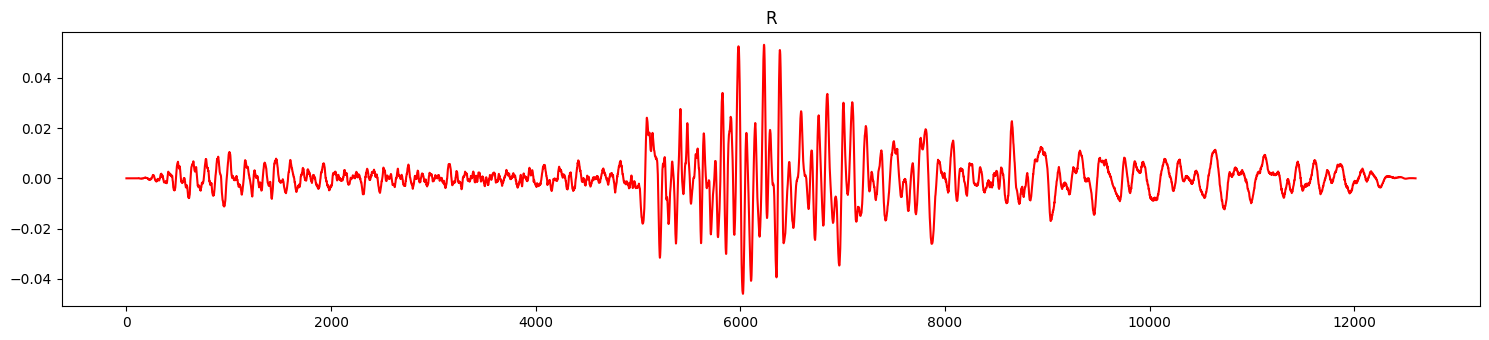

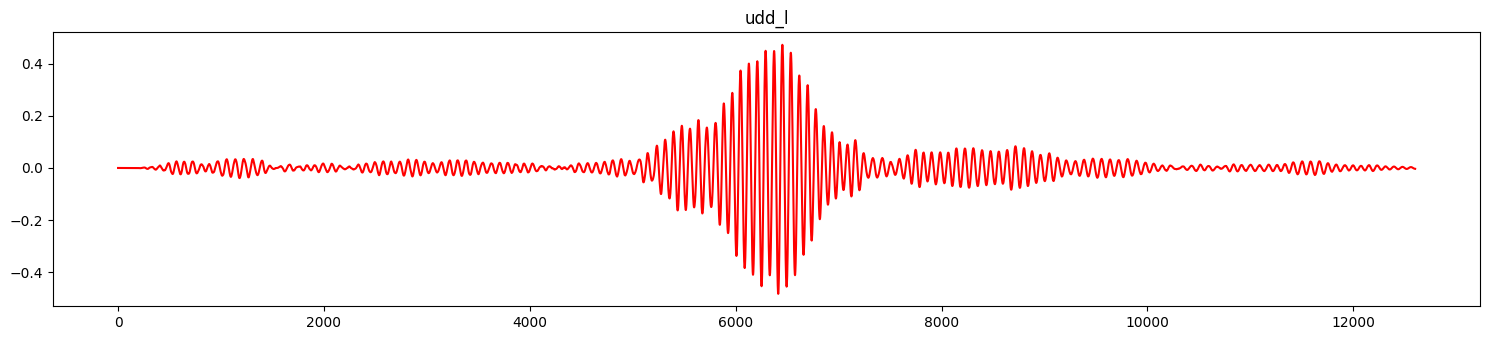

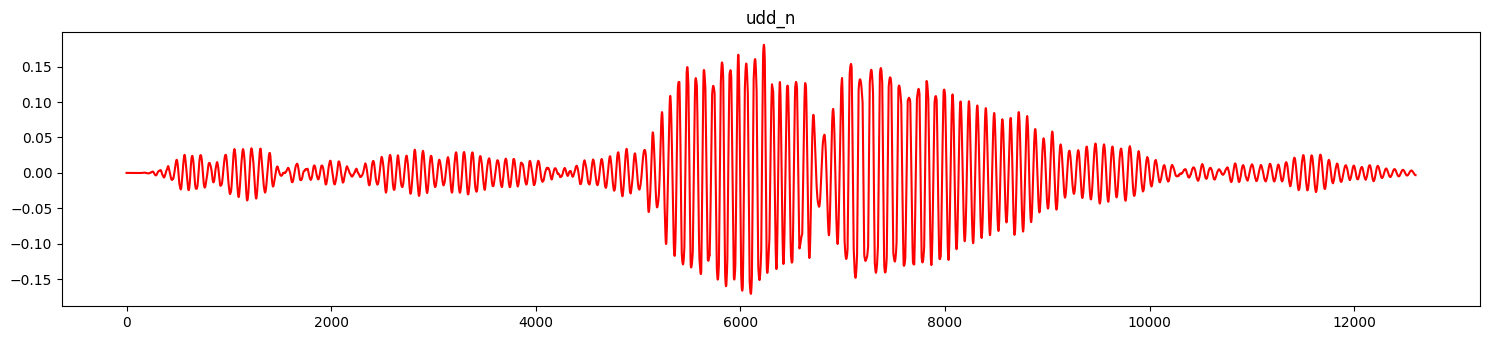

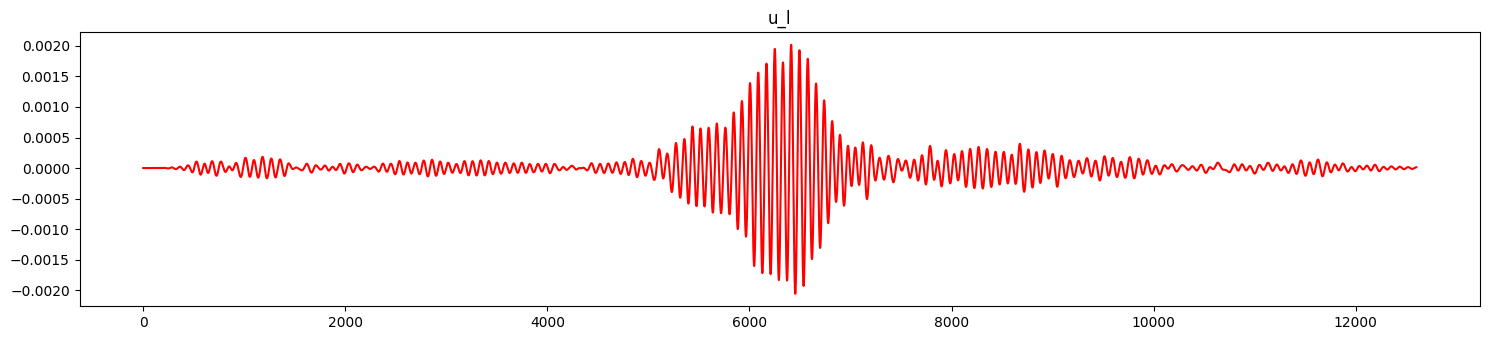

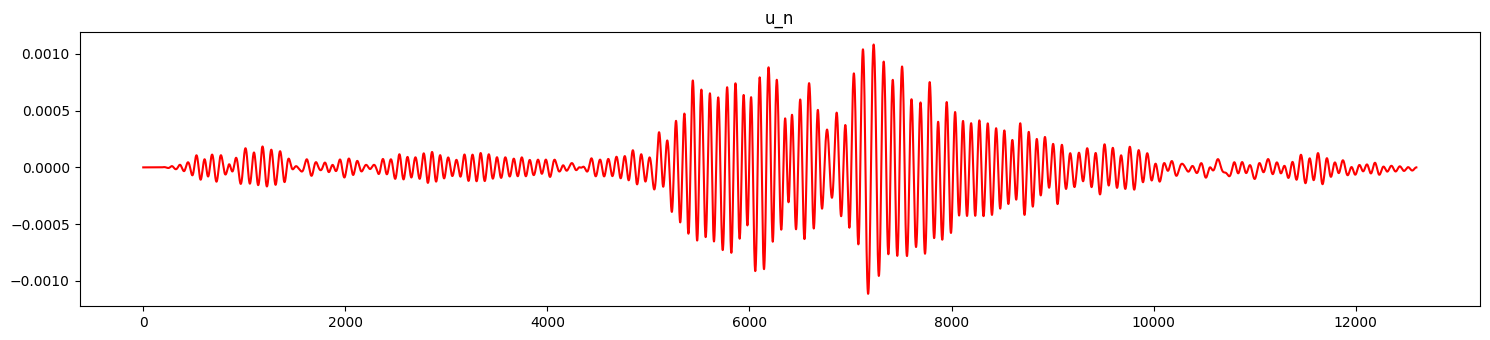

In [ ]:
R=files_data[13].acc_values_sampled.reshape((NDOF, -1))
t_l,u_l,ud_l,udd_l = Generalized_Alpha(K,M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM) # Relative Response
t_n,u_n,ud_n,udd_n = Generalized_Alpha_NonLinear((np.array([k]) , np.array([0.0005]), np.array([0.2])),M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM) # Relative Response
plot_series((R).reshape(-1),'R')
plot_series((udd_l).reshape(-1),'udd_l')
plot_series((udd_n).reshape(-1),'udd_n')
plot_series((u_l).reshape(-1),'u_l')
plot_series((u_n).reshape(-1),'u_n')

In [ ]:
def max_abolute(x):
  return max(abs(x.max()),abs(x.min()))

In [ ]:
import statistics

max_u_detected_l=[]
max_u_detected_n=[]

avg_u_detected_l=[]
avg_u_detected_n=[]

for file_data in files_data:
  #print(file_data.ID,file_data.name)
  R=file_data.acc_values_sampled.reshape((NDOF, -1))
  t_l,u_l,ud_l,udd_l = Generalized_Alpha(K,M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM)
  t_n,u_n,ud_n,udd_n = Generalized_Alpha_NonLinear((np.array([k]) , np.array([0.0001]), np.array([0.2])),M,C,u0,ud0,dt,R,gamma,beta,alphaF,alphaM)

  print(f'max u = {max_abolute(u_l):.5f} || max u_n = {max_abolute(u_n):.5f} || nonlinear/linear = {max_abolute(u_n)/max_abolute(u_l):.5f} || avg u = {np.absolute(u_l).mean():.5f} || avg u_n = {np.absolute(u_n).mean():.5f} || #{file_data.ID:2.0f} || {file_data.name}')
  max_u_detected_l.append(max_abolute(u_l))
  max_u_detected_n.append(max_abolute(u_n))
  avg_u_detected_l.append(np.absolute(u_l).mean())
  avg_u_detected_n.append(np.absolute(u_n).mean())

  file_data.u_r   =u_n.reshape(-1)
  file_data.ud_r  =ud_n.reshape(-1)
  file_data.udd_r =udd_n.reshape(-1)
  file_data.t     =t_n.reshape(-1)

print(f'max_u_detected Linear u = {max(max_u_detected_l):.5f} || mean = {statistics.mean(max_u_detected_l)} || mean of mean = {statistics.mean(avg_u_detected_l)}')
print(f'max_u_detected Nonlin u = {max(max_u_detected_n):.5f} || mean = {statistics.mean(max_u_detected_n)} || mean of mean = {statistics.mean(avg_u_detected_n)}')


max u = 0.00048 || max u_n = 0.00111 || nonlinear/linear = 2.30941 || avg u = 0.00004 || avg u_n = 0.00007 || # 1 || Anza_04apr2020_ce23287p
max u = 0.00557 || max u_n = 0.00562 || nonlinear/linear = 1.00944 || avg u = 0.00033 || avg u_n = 0.00050 || # 2 || borregosprings_10jun2016_37374687_ce23287p
max u = 0.00036 || max u_n = 0.00034 || nonlinear/linear = 0.95629 || avg u = 0.00004 || avg u_n = 0.00004 || # 3 || Banning_11Jan2010_CE23287P
max u = 0.00155 || max u_n = 0.00162 || nonlinear/linear = 1.04317 || avg u = 0.00013 || avg u_n = 0.00015 || # 4 || cabazon_08may2018_38167848_ce23287p
max u = 0.00057 || max u_n = 0.00052 || nonlinear/linear = 0.91452 || avg u = 0.00006 || avg u_n = 0.00005 || # 5 || Beaumont_16Jan2010_CE23287P
max u = 0.00418 || max u_n = 0.00689 || nonlinear/linear = 1.64649 || avg u = 0.00042 || avg u_n = 0.00108 || # 6 || calexico_04apr2010_14607652_CE23287P
max u = 0.00303 || max u_n = 0.00153 || nonlinear/linear = 0.50442 || avg u = 0.00025 || avg u_n = 0.00

In [ ]:
save_object_with_pickle(major_folder_path_2,'all_eq_processed_data_ID_m_SDOF_nonlinear_v003',files_data)